In [126]:
%matplotlib notebook
import sys, os, tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [5]:
download = False

url = 'https://people.cs.pitt.edu/~mzhang/cs1699/cifar10.zip'

def download_and_unzip(url, output_path):
    import urllib, io, zipfile
    with urllib.request.urlopen(url) as f:
        zip_file = zipfile.ZipFile(io.BytesIO(f.read()))
        zip_file.extractall(path=output_path)

data_root = './cifar10'
train_set_dir = os.path.join(data_root, 'cifar10_train')
test_set_dir = os.path.join(data_root, 'cifar10_test')

if download:
    download_and_unzip(url, data_root)
    
os.listdir(data_root)

['cifar10_train', 'cifar10_test']

In [6]:
sorted(os.listdir(train_set_dir))

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Part A - Custom data loader

In [7]:
class XorDataset(torch.utils.data.Dataset):
    
    def __init__(self, root_dir, device):
        self.inputs = [
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1],
        ]
        self.labels = [0, 1, 1, 0] 
        self.device = device
    
    @property
    def data_size(self):
        return 2

    @property
    def label_size(self):
        return 2
    
    def __len__(self):
        return 4

    def __getitem__(self, idx):
        input_ = torch.as_tensor(
            self.inputs[idx], dtype=torch.float32, device=self.device
        )
        label = F.one_hot(
            torch.as_tensor(self.labels[idx]), self.label_size
        ).to(dtype=torch.float32, device=self.device)
        return input_, label
    
XorDataset('asdf', device='cpu')[0]

(tensor([0., 0.]), tensor([1., 0.]))

In [73]:
class CifarDataset(torch.utils.data.Dataset):  
    label_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def __init__(self, images, labels, device):
        super().__init__()
        assert len(images) == len(labels)
        self.images = images
        self.labels = labels
        self.device = device
    
    @classmethod
    def from_dir(cls, root_dir, device):
        images, labels = [], []
        for label_idx, label in enumerate(cls.label_map):
            label_dir = os.path.join(root_dir, label)
            for image_name in sorted(os.listdir(label_dir)):
                image_file = os.path.join(label_dir, image_name)
                images.append(image_file)
                labels.append(label_idx)
        return cls(images, labels, device)

    @property
    def data_size(self):
        return 3 * 32 * 32

    @property
    def label_size(self):
        return 10

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_file = self.images[idx]
        image = torchvision.io.read_image(image_file)
        label = self.labels[idx]
        assert image.shape == (3, 32, 32) and label < 10

        # convert image and label to tensors
        image = torch.as_tensor(
            image.reshape(self.data_size) / 255 - 0.5,
            dtype=torch.float32,
            device=self.device
        )
        label = F.one_hot(
            torch.as_tensor(label), self.label_size
        ).to(self.device, dtype=torch.float32)
    
        return image, label
    
    def select(self, inds):
        images = [self.images[i] for i in inds]
        labels = [self.labels[i] for i in inds]
        return CifarDataset(images, labels, self.device)
    
    def sample(self, n, seed=None):
        np.random.seed(seed)
        shuffled_inds = np.random.permutation(len(self))
        sampled_inds = shuffled_inds[:n]
        return self.select(sampled_inds)
    
    def split(self, n, seed=None):
        np.random.seed(seed)
        shuffled_inds = np.random.permutation(len(self))
        train_inds, test_inds = np.split(shuffled_inds, [n])
        train_data = self.select(train_inds)
        test_data = self.select(test_inds)
        return train_data, test_data    

train_dataset = CifarDataset.from_dir(train_set_dir, device='cpu')
train_dataset[0]

(tensor([0.2922, 0.2922, 0.3000,  ..., 0.4529, 0.4529, 0.4529]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

<IPython.core.display.Javascript object>


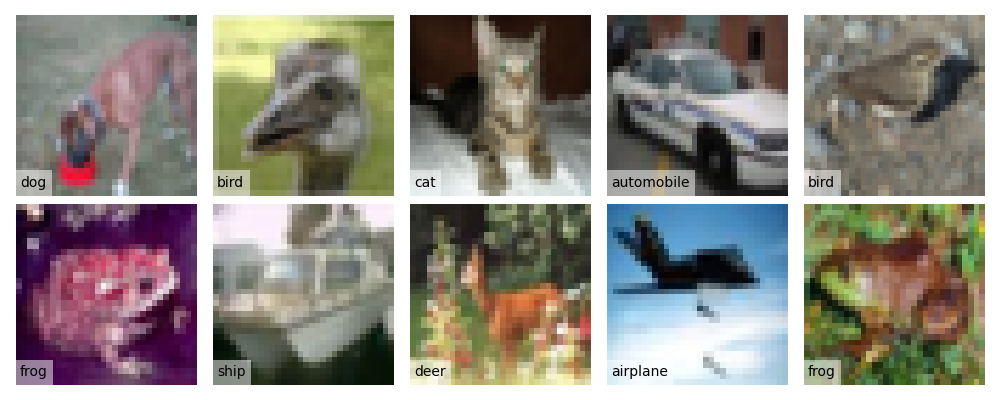

In [83]:
n_rows = 2
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

N = len(train_dataset)
inds = np.random.choice(range(N), size=(n_rows, n_cols), replace=False)

for row in range(n_rows):
    for col in range(n_cols):
        ax = axes[row, col]

        image, label = train_dataset[inds[row, col]]
        image = image.reshape(3, 32, 32) + 0.5
        label = train_dataset.label_map[label.argmax()]

        ax.imshow(image.permute(1, 2, 0))
        ax.text(
            0.024, 0.048, f'{label}', transform=ax.transAxes,
            bbox=dict(alpha=0.5, fc='white', lw=0)
        )
        ax.axis('off')

fig.tight_layout()

# Part B - Training neural networks

In [113]:
class MultiLayerPerceptronModel(torch.nn.Module):

    def __init__(self, n_input, n_hidden, n_output, activ_fn, dropout):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_output)
        self.activ_fn = getattr(torch.nn.functional, activ_fn)
        assert dropout == 0, 'not implemented'

    def forward(self, x):
        x = self.activ_fn(self.fc1(x))
        return self.fc2(x)

In [133]:
df = pd.DataFrame(columns=['iteration', 'phase', 'loss', 'accy'])
df

,iteration,phase,loss,accy


In [138]:
df

,iteration,phase,loss,accy
0,0,test,1,1
1,1,test,1,1


In [148]:
df.iteration.values

array([0, 1])

In [161]:
class TrainingPlot(object):
    
    def __init__(self):
        
        # create subplots for loss and accuracy
        self.fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].set_ylabel('loss')
        ax[1].set_ylabel('accuracy')
        for ax_ in ax:
            ax_.set_axisbelow(True)
            ax_.grid(linestyle=':')
            ax_.set_xlabel('iteration')
        self.fig.tight_layout()
        
        # store data and artists for interactive ploting
        self.data = pd.DataFrame(columns=['iter', 'phase', 'loss', 'accy'])

        self.train_loss_line = ax[0].plot([], [], label='train')[0]
        self.test_loss_line  = ax[0].plot([], [],  label='test')[0]
        self.train_accy_line = ax[1].plot([], [], label='train')[0]
        self.test_accy_line  = ax[1].plot([], [],  label='test')[0]
        
    def draw(self, eps=1e-8):
        ax = self.fig.get_axes()
        ax[0].set_xlim(0, self.data.iter.max() * 1.1 + eps)
        ax[0].set_ylim(0, self.data.loss.max() * 1.1 + eps)
        ax[1].set_xlim(0, self.data.iter.max() * 1.1 + eps)
        ax[1].set_ylim(0, self.data.accy.max() * 1.1 + eps)
        self.fig.canvas.draw()
        
    def update_train(self, iteration, loss, accy):
        self.data.loc[len(self.data)] = [iteration, 'train', loss.item(), accy.item()]
        
        data = self.data.groupby(['iter', 'phase']).mean()
        data = data.reset_index().set_index('phase')
        train = data.loc['train']
        if isinstance(train, pd.Series):
            return
        
        self.train_loss_line.set_xdata(train.iter)
        self.train_loss_line.set_ydata(train.loss)

        self.train_accy_line.set_xdata(train.iter)
        self.train_accy_line.set_ydata(train.accy)

        self.draw()
        
    def update_test(self, iteration, loss, accy):
        self.data.loc[len(self.data)] = [iteration, 'test', loss.item(), accy.item()]
        
        data = self.data.groupby(['iter', 'phase']).mean()
        data = data.reset_index().set_index('phase')
        test = data.loc['test']
        if isinstance(test, pd.Series):
            return
        
        self.test_loss_line.set_xdata(test.iter)
        self.test_loss_line.set_ydata(test.loss) 
        
        self.test_accy_line.set_xdata(test.iter)
        self.test_accy_line.set_ydata(test.accy)
        
        self.draw()

<IPython.core.display.Javascript object>


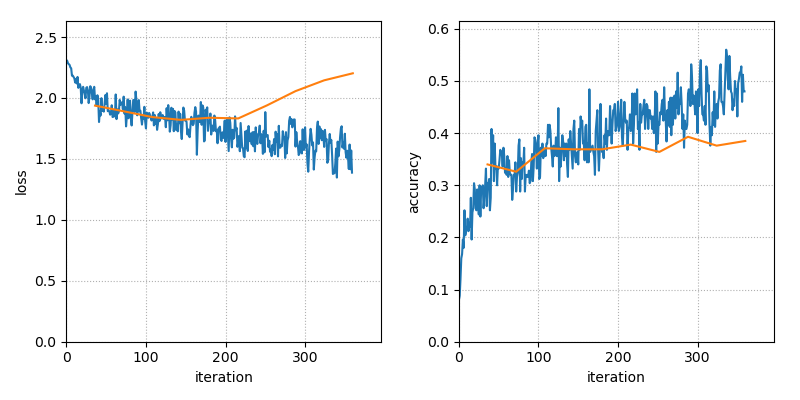

Epoch 1 / 10
Training...
100%|██████████| 36/36 [01:19<00:00,  2.21s/it]
Testing...
100%|██████████| 4/4 [00:07<00:00,  1.91s/it]
Epoch 2 / 10
Training...
100%|██████████| 36/36 [00:07<00:00,  4.90it/s]
Testing...
100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
Epoch 3 / 10
Training...
100%|██████████| 36/36 [00:07<00:00,  4.85it/s]
Testing...
100%|██████████| 4/4 [00:00<00:00,  5.41it/s]
Epoch 4 / 10
Training...
100%|██████████| 36/36 [00:08<00:00,  4.42it/s]
Testing...
100%|██████████| 4/4 [00:00<00:00,  5.33it/s]
Epoch 5 / 10
Training...
100%|██████████| 36/36 [00:06<00:00,  5.24it/s]
Testing...
100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
Epoch 6 / 10
Training...
100%|██████████| 36/36 [00:05<00:00,  6.00it/s]
Testing...
100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
Epoch 7 / 10
Training...
100%|██████████| 36/36 [00:05<00:00,  6.88it/s]
Testing...
100%|██████████| 4/4 [00:00<00:00,  7.09it/s]
Epoch 8 / 10
Training...
100%|██████████| 36/36 [00:05<00:00,  6.71it/s]
Testing...
100%|█

In [163]:
def compute_accuracy(predictions, labels):
    return (predictions.argmax(dim=1) == labels.argmax(dim=1)).float().mean()

def training(
    root_dir, batch_size, n_hidden, activ_fn, dropout,
    optimizer, weight_decay, learning_rate, n_epochs,
    **kwargs
):
    # split dataset and create data loaders
    dataset = CifarDataset.from_dir(root_dir, device='cuda').sample(10000)
    train_set, test_set = dataset.split(n=9000, seed=0)
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=True
    )
    N = len(train_set)

    # define model architecture
    model = MultiLayerPerceptronModel(
        dataset.data_size, n_hidden, dataset.label_size, activ_fn, dropout
    ).cuda()
    
    # initialize loss function and optimizer
    loss_fn = F.cross_entropy
    optim = getattr(torch.optim, optimizer)(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay, **kwargs
    )
    
    # setup training plot
    plot = TrainingPlot()
    
    # start training loop
    iteration = 0
    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1} / {n_epochs}')

        print('Training...')
        for i, (images, labels) in enumerate(tqdm.tqdm(train_loader, file=sys.stdout)):
            
            predictions = model.forward(images)
            loss = loss_fn(predictions, labels)
            accy = compute_accuracy(predictions, labels)
            plot.update_train(iteration, loss, accy)
    
            loss.backward()
            optim.step()
            iteration += 1
        
        print('Testing...')
        for i, (images, labels) in enumerate(tqdm.tqdm(test_loader, file=sys.stdout)):
            with torch.no_grad():
                predictions = model.forward(images)
                loss = loss_fn(predictions, labels)
                accy = compute_accuracy(predictions, labels)
                plot.update_test(iteration, loss, accy)
            
    return model

model = training(
    train_set_dir,
    batch_size=250,
    n_hidden=128,
    activ_fn='tanh',
    dropout=0.0,
    optimizer='SGD',
    learning_rate=1e-2,
    weight_decay=0,
    n_epochs=10
)

## Experiment 1: learning rate

In [ ]:
%%time

lr_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
lr_models = []

for lr in lr_values:
    model = training(
        train_set_dir,
        batch_size=250,
        n_hidden=128,
        activ_fn='tanh',
        dropout=0.0,
        optimizer='SGD',
        learning_rate=lr,
        weight_decay=0,
        n_epochs=10
    )
    lr_models.append(lr_values)

In [ ]:

)